# 7장 로지스틱 회귀를 이용한 분류

자료 출처: [ISLP (An Introduction to Statistical Learning with Applications in Python)](https://www.statlearning.com/)

## 7.1 개요

앞에서 배운 선형 회귀 모델에서는 종속변수 또는 반응변수(response variable) $Y$가 정량적(quantitative)이지만, 많은 상황에서 반응변수는 **정성적**(qualitative)이다. 정성적 변수를 범주형(categorical)이라고도 한다.

정성적 반응에 대한 추정 및 예측을 **분류**(classification)라고 부른다. 가령 스팸 메일 예를 생각해보자. 이 경우 정성적 반응을 예측하는 것은 메일이 스팸인지 햄인지 예측하는 것으로서 관측을 어떤 범주나 등급에 할당하는 것이기 때문에 분류로 지칭될 수 있다.

분류 기법에는 여러가지 있다. 로지스틱 회귀(logistic regression), 선형판별 분석(linear discriminant analysis), K-최근접이웃(K-nearest neighbors) 등이 널리 사용되는 분류 기법이다. 또한 일반가산 모델(generalized additive model), 트리(tree), 랜덤 포레스트(random forest), 부스팅(boosting), 서포트 벡터 머신(support vector machine) 등 컴퓨팅 집약적인 방법도 사용된다. 본 장에서는 이 중에서 로지스틱 회귀를 다룬다.

### 분류 문제 예

- 온라인 뱅킹 서비스는 사용자의 IP 주소, 과거 거래 내역 등을 기반으로 어떤 사이트에서 수행중인 거래가 **금융사기**인지 여부를 파악할 수 있어야 한다.


- 생물학자는 여러 환자에 대한 DNA 염기 서열 데이터를 바탕으로 어떤 DNA 변이가 **해로운지**(질병을 유발하는지), 그렇지 않은지를 파악하려고 한다.


- 어떤 사람이 **세 가지 질환** 중 하나에 기인할 수 있는 일련의 증상을 가지고 응급실에 도착한다. 이 사람은 세 가지 질환 중 어떤 것에 속하는가?

### Default 데이터세트 사례

ISLP에서 제공하는 "Default.csv" 데이터세트를 불러들인다. 우리는 이 데이터를 사용해 사람들이 신용카드 결제에서 디폴트(`default`: 채무불이행 또는 연체)가 발생할지 예측하는 데 관심이 있다. **시뮬레이션** 데이터세트이며, 예측변수로는 개인들의 연간 소득(`income`)과 월간 신용카드 사용액(`balance`) 등이 있다.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
pd.set_option("display.precision", 3)

In [2]:
df = pd.read_csv('../Data/Default.csv')
df.head()

,default,student,balance,income
0,No,No,729.526,44361.625
1,No,Yes,817.180,12106.135
2,No,No,1073.549,31767.139
3,No,No,529.251,35704.494
4,No,No,785.656,38463.496


**Default 데이터세트 변수**

- `default`: 채무불이행 여부(`Yes`/`No`)
- `student`: 학생 여부(`Yes`/`No`)
- `balance`: 월간 신용카드 사용액
- `income`: 연간 소득

In [3]:
df.describe(include='all')

,default,student,balance,income
count,10000,10000,10000.000,10000.000
unique,2,2,NaN,NaN
top,No,No,NaN,NaN
freq,9667,7056,NaN,NaN
mean,NaN,NaN,835.375,33516.982
std,NaN,NaN,483.715,13336.640
min,NaN,NaN,0.000,771.968
25%,NaN,NaN,481.731,21340.463
50%,NaN,NaN,823.637,34552.645
75%,NaN,NaN,1166.308,43807.729


**Default 데이터세트 시각적 분석**

아래 그림 7.1은 `income`(연간 소득)과 `balance`(카드 사용액)에 대해 디폴트가 발생한 그룹과 그렇지 않은 그룹을 구별하여 산점도 및 상자그림(boxplot)을 그린 것이다. 왼쪽 그림에서 오렌지색은 디폴트인 경우이고 파란색은 그렇지 않은 경우를 나타낸다.(전체 데이터에서 디폴트 비율이 약 3%로 너무 적어서 채무를 이행한 사람들은 전체가 아니라 일부만 표시한 것임) 디폴트인 경우가 그렇지 않은 경우에 비해 카드 사용액이 더 많은 경향이 있는 것을 알 수 있다. 그림 오른쪽의 상자그림에서 첫 번째는 디폴트 그룹과 디폴트가 아닌 그룹 각각에 대해 `balance`의 분포를 보여주고, 두 번째는 `income`의 분포를 보여준다. `balance`의 경우에는 두 그룹의 차이가 크지만, `income`의 경우에는 두 그룹 간에 큰 차이가 없는 것을 알 수 있다. 

**그림 7.1.** Default 데이터세트. `income`과 `balance`에 대해 디폴트 여부별로 산점도 및 상자그림을 그린 것이다.

![Default 데이터세트](https://raw.githubusercontent.com/pilsunchoi/images/main/7-1.png)

- 그림 출처: ISLP, FIGURE 4.1

## 7.2 로지스틱 회귀

Default 데이터세트에서 우리의 관심은 신용카드 사용자들의 디폴트(채무불이행) 여부를 잘 예측하는 것이다. `default` 변수가 Yes/No의 범주형 변수이기 때문에 회귀 분석을 위해서는 이를 **더미 변수**(dummy variable)로 바꿔야 한다. `default` 변수값이 Yes인 경우 1, No인 경우 0의 값을 부여해 이를 반응변수 $Y$라 하자. 

$$
Y=
\begin{cases}
0, & \text{if default=No} \\[2ex]
1, & \text{if default=Yes} \\[2ex]
\end{cases}
$$

위와 같은 이항(binary) 반응의 경우, 앞에서 배운 **선형 회귀 모델로 추정하는 것도 나름대로 의미**가 있다. 선형 회귀를 사용하여 얻은 **적합값 $ \hat Y = X \hat\beta$을 채무불이행의 확률**, 즉 $\Pr(Y=1)$에 대한 추정값으로 해석하는 것이다. 이 경우 $Y$, 즉 채무이행 여부에 대한 예측 작업도 수행할 수 있는데, $\hat Y >0$.5이면 채무불이행, 그렇지 않으면 채무이행으로 예측할 수 있다. 

그러나 선형 회귀를 사용하는 경우, 아래 그림 7.2의 왼쪽 그림에서 보듯이 일부 추정치가 0과 1 사이의 범위를 벗어나는 문제가 발생한다.(추정선이 수평선이 아닌 한, 0과 1 사이의 범위를 벗어나는 구간이 발생할 것이다.) 즉, 확률이 마이너스가 되거나 1보다 큰 경우가 발생할 수 있다. 

이런 경우를 없애고 아래 그림 7.2의 오른쪽 그림과 같이 되도록 모델을 설정한 것이 **로지스틱 모델**이다. 로지스틱 회귀의 경우, 아래 그림에서 보듯이 `balance` 값이 낮은 수준일 때, 디폴트 확률이 0에 가깝지만 절대 0보다 낮게 예측되지는 않는다. 또한 `balance` 값이 높은 경우, 디폴트 확률이 1에 가까울 수 있지만 그보다 높게 예측되지는 않는다. 

**그림 7.2.** Default 데이터 분류. 양쪽 그림에서 0과 1의 수평 점선 상에 표시된 오렌지색 눈금 표시들은 각 관측들의 디폴트 여부(No 또는 Yes)를 의미하는 0과 1의 값이다. 왼쪽 패널에서 파란색 직선은 선형 회귀를 사용하여 추정된 디폴트 확률로서 일부 추정 확률이 음수이다! 오른쪽 패널에서 파란색 곡선은 로지스틱 회귀를 사용하여 추정된 디폴트 확률로서 모든 확률은 0과 1 사이에 있다.

![Default 데이터 분류](https://raw.githubusercontent.com/pilsunchoi/images/main/7-2.png)

- 그림 출처: ISLP, FIGURE 4.2

### 로지스틱 회귀

`Default` 데이터세트에서 반응변수 $Y$는 0(채무이행)과 1(채무불이행)의 값을 갖는 범주형 변수이다. 로지스틱 회귀 분석은 $Y$를 직접 모델링하는 대신 $Y$가 **1의 범주에 속할 확률을 모델링**한다.

디폴트 확률을 예측하는 예측변수로 `balance`(카드 사용액) 변수 하나만 생각해보자. `balance`가 주어졌을 때의 디폴트 확률을 $\Pr⁡(Y=1 \mid \text{balance})$로 표현할 수 있다. 이를 간단히 $p⁡(\text{balance})$로 표기하기로 한다. 이 값은 확률이므로 0과 1 사이이다. 추정 후 `balance` 값이 주어지면 디폴트 여부를 예측할 수 있다. 예를 들어, $p⁡(\text{balance})>0.5$이면, $Y=1$로 예측하는 식이다. 만약 디폴트 위험을 보수적으로 예측하기를 원하는 경우에는 가령 $p(\text{balance})>0.1$ 등 더 낮은 분계점(threshold)을 선택할 수도 있다.

앞에서도 설명했듯이 0 또는 1로 코딩된 이항 반응을 **직선으로 피팅**하는 경우, ($X$값에 제한이 있지 않는 한) 기본적으로 $X$의 일부 값에 대해 $p(x)<0$을 예측하고, 또 다른 값에 대해서는 $p(x)>1$을 예측할 가능성이 발생한다. 이 문제를 피하기 위해서는 이항 반응을 직선 함수로 피팅하는 대신 항상 0과 1 사이의 값을 갖도록 하는 함수로 피팅시키면 된다. 아래 그림 7.3과 같은 모양을 가진 **로지스틱 함수**(logistic function)를 사용한 것이 바로 로지스틱 모델이다.

**그림 7.3.** 로지스틱 함수.

![로지스틱 함수](https://raw.githubusercontent.com/pilsunchoi/images/main/7-3.png)

- 그림 출처: Wikipedia, "[Logistic function](https://en.wikipedia.org/wiki/Logistic_function)".

로지스틱 함수를 식으로 표현하면 다음과 같다.

$$
f(x) = \frac {1}{1+e^{-x}}~~또는~~\frac {e^{x}}{1+e^{x}}
$$

위 식의 $x$에 어떤 값을 집어 넣든 $f(x)$는 0과 1 사이의 범위를 벗어나지 않는다. 따라서 위 식의 $x$에 예측변수의 선형결합(linear combination)인 $\beta_0 + \beta_1 X$를 대입한 것이 로지스틱 회귀 모델로서 다음과 같다.

$$
p(X) = \frac {e^{\beta_0 + \beta_1 X}}{1+e^{\beta_0 + \beta_1 X}} \tag{7.1}
$$

앞에서 로지스틱 회귀 분석은 $Y$를 직접 모델링하는 대신 $Y$가 1의 범주에 속할 확률을 모델링한다고 언급했는데, 식 7.1에서 그 의미를 알 수 있을 것이다. 좌변이 $Y$가 아니라 $p(X)$, 즉 $\Pr⁡(Y=1 \mid X)$이다.

위 식 7.1을 약간 변형하면 다음과 같이 된다.

$$
{\rm ln}\left(\frac {p(X)}{1−p(X)}\right) =\beta_0 + \beta_1 X  \tag{7.2}
$$

선형 회귀 모형에서 $\beta_1$은 $X$가 1단위 증가시 $Y$의 평균적 변화이다. 하지만 식 7.1과 7.2에서 알 수 있듯이 로지스틱 모형에서는 $p(X)$와 $X$의 관계가 직선이 아니기 때문에 $\beta_1$은 $X$의 $p(X)$에 대한 한계효과(marginal effect)에 해당하지 않는다. 식 7.2의 좌변은 **log-odds** 또는 **logit**으로 불리며, 이에 따라 로지스틱 모델을 **로짓(logit)** 모델이라고도 부른다. 

위 식 7.1에서 알 수 있듯이 로지스틱 회귀 모델에서 $X$의 $p(X)$에 대한 한계효과는 $X$의 현재 값에 따라 달라지는 등 선형 회귀와는 다르다. 그러나 어찌됐든 $\beta_1$이 플러스이면 $X$ 증가시 $p(X)$가 높아지고, $\beta_1$이 마이너스이면 $X$ 증가시 $p(X)$가 낮아진다는 사실은 선형 회귀와 동일하다. 반면 $p(X)$와 $X$ 사이에 직선 관계가 없으며, $X$의 단위 변화 당 $p(X)$의 변화가 $X$값이 무엇이냐에 따라 달라진다는 점은 선형 회귀와 다른 점이다. 이는 앞 그림 7.2의 오른쪽 패널에서도 시각적으로 확인할 수 있다.

### 최대가능도 추정

선형 회귀 모형은 OLS(통상최소제곱) 방법으로 미지의 선형 회귀 계수를 추정한다. 이에 반해 로지스틱 회귀 모델은 **최대가능도**(maximum likelihood) 방법으로 추정하는데, 기본 직관은 다음과 같다. 앞의 로지스틱 회귀 모델 식을 사용하여 각 카드 사용자에 대해 디폴트 확률을 추정하게 되는데, 그 추정 확률 $\hat p(x_i)$을 실제 관측된 디폴트 여부와 가능한 한 가깝게 $\beta_0$ 및 $\beta_1$에 대한 추정치를 구하는 것이다. 다시 말해, $p(X)$ 모형에 $\hat \beta_0$ 및 $\hat \beta_1$을 집어 넣었을 때, 디폴트가 발생한 모든 카드 사용자에 대해서는 가능한 한 1에 가까운 숫자가 나오게 하고, 그렇지 않은 모든 카드 사용자에게는 가능한 한 0에 가까운 숫자가 나오게 하도록 하려는 것이다.

이 직관은 **가능도함수**(likelihood function)라는 다음의 식을 최대화하는 $\hat \beta_0$ 및 $\hat \beta_1$을 선택하는 것을 의미한다.

$$
l(\beta_0,\beta_1)=\mathop{\prod}_{y_i=1} p(x_i) \mathop{\prod}_{y_i=0} (1-p(x_i))
$$

최대가능도는 **비선형** 모델에 적합한 방법이며, 매우 광범위하게 사용되는 접근 방식이다. 선형 회귀 모형의 최소제곱 접근은 최대가능도 방법의 특별한 경우에 해당한다. 최대가능도 추정은 파이썬이나 R과 같은 통계 소프트웨어 패키지를 사용하여 쉽게 실행할 수 있다.

### 선형 회귀 vs 로지스틱 회귀 예시

먼저 예시적으로 간단한 `x`, `y` 데이터를 만들어 `data`라는 데이터프레임으로 지정한다. 그런 다음 산점도를 그린다.

In [4]:
data = {'x': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
        'y': [0, 0, 0, 0, 0, 1, 1, 0, 1, 1]}
data = pd.DataFrame(data)
data

,x,y
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
5,5,1
6,6,1
7,7,0
8,8,1
9,9,1


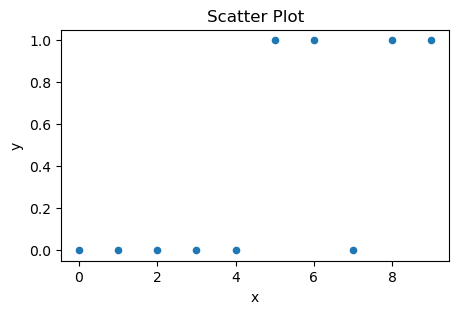

In [5]:
# plt.rcParams['font.size'] = '8' # 전체적으로(globally) 폰트 크기 조정
plt.figure(figsize=(5,3))
plt.scatter(data['x'], data['y'], s=20)
plt.title('Scatter Plot', fontsize=12)
plt.xlabel('x', fontsize=10)
plt.ylabel('y', fontsize=10)
plt.show()

**선형 회귀 모델**

위 시뮬레이션 데이터에 대해 선형 회귀 모델을 피팅한 다음, 각 `x`값에 대해서 확률 추정값(적합값)을 구해 산점도 위에 그린다. 이 경우 앞에서 우려한 대로 일부 적합값이 마이너스 값을 갖는 것을 볼 수 있다.

In [6]:
model = smf.ols('y ~ x', data)
olsfit = model.fit()
y_pred = olsfit.predict(data['x'])

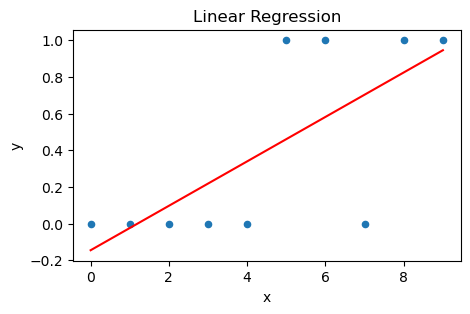

In [7]:
plt.figure(figsize=(5,3))
plt.scatter(data['x'], data['y'], s=20)
plt.plot(data['x'], y_pred, color='red')
plt.title('Linear Regression', fontsize=12)
plt.xlabel('x', fontsize=10)
plt.ylabel('y', fontsize=10)
plt.show()

**로지스틱 회귀 모델**

다음은 `statsmodels.formula.api` 모듈의 `logit()` 함수를 이용한 추정이다. 동일한 시뮬레이션 데이터에 대해 이번에는 로지스틱 회귀 모델을 피팅한 다음, 각 `x`값에 대해서 확률 추정값(적합값)을 구해 산점도 위에 그린다. 이 경우 선형 회귀와 같은 문제가 발생하지 않는 것을 알 수 있다. 즉, 모든 적합값이 0과 1 사이에 위치한다.

In [8]:
model = smf.logit('y ~ x', data)
logitfit = model.fit()
y_pred = logitfit.predict(data['x'])

Optimization terminated successfully.
         Current function value: 0.355402
         Iterations 7


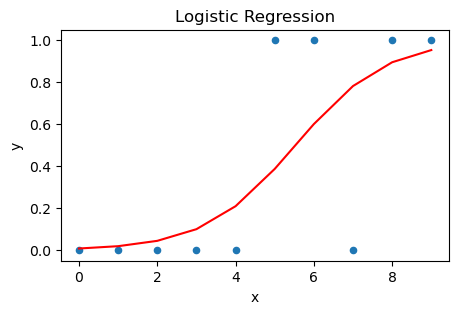

In [9]:
plt.figure(figsize=(5,3))
plt.scatter(data['x'], data['y'], s=20)
plt.plot(data['x'], y_pred, color='red')
plt.title('Logistic Regression', fontsize=12)
plt.xlabel('x', fontsize=10)
plt.ylabel('y', fontsize=10)
plt.show()

### Default 데이터세트 로지스틱 회귀

앞에서 예시적으로 사용한 `Default` 데이터세트에서 우선 `balance` 변수 하나만을 사용해 디폴트 확률을 예측하는 로지스틱 회귀 모델을 실행해보자. 먼저 범주형 변수인 `default` 변수를 **더미 변수**(dummy variable)로 인코딩해야 한다. 즉 `default` 변수 값이 Yes인 경우 1, No인 경우 0의 값을 부여해 이를 `default1` 이름으로 지정한다. 

In [10]:
df['default1'] = [0 if default == 'No' else 1 for default in df.default]
df.head()

,default,student,balance,income,default1
0,No,No,729.526,44361.625,0
1,No,Yes,817.180,12106.135,0
2,No,No,1073.549,31767.139,0
3,No,No,529.251,35704.494,0
4,No,No,785.656,38463.496,0


In [11]:
df.describe()

,balance,income,default1
count,10000.000,10000.000,10000.000
mean,835.375,33516.982,0.033
std,483.715,13336.640,0.179
min,0.000,771.968,0.000
25%,481.731,21340.463,0.000
50%,823.637,34552.645,0.000
75%,1166.308,43807.729,0.000
max,2654.323,73554.233,1.000


다음은 `smf.logit`를 이용한 로지스틱 회귀 모델 추정 결과이다. 반응변수로는 범주형 변수인 `default`가 아니라 이를 더미변수로 인코딩한 `default1`을 사용해야 한다.

In [12]:
est = smf.logit('default1 ~ balance', data=df).fit()
print(est.summary())

Optimization terminated successfully.
         Current function value: 0.079823
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:               default1   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9998
Method:                           MLE   Df Model:                            1
Date:                Wed, 03 Sep 2025   Pseudo R-squ.:                  0.4534
Time:                        06:52:15   Log-Likelihood:                -798.23
converged:                       True   LL-Null:                       -1460.3
Covariance Type:            nonrobust   LLR p-value:                6.233e-290
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -10.6513      0.361    -29.491      0.000     -11.359      -9.943
balance        0.0055      0

결과를 보면 $\beta_1 = 0.0055$이다. 이것은 `balance`의 증가가 디폴트 확률을 증가시키는 방향으로 영향을 미친다는 것을 의미한다. 정확히 말하면 `balance`가 1단위 증가하면 디폴트의 log odds가 0.0055단위 증가하는 것을 의미한다. 

선형 회귀와 마찬가지로 표준오차를 계산하여 계수 추정의 정확도를 측정할 수 있다. 표에 나와 있는 $z$-통계량은 선형 회귀의 $t$-통계량과 동일한 역할을 한다. 예를 들어 $\beta_1$의 $z$-통계량은 $\hat \beta_1 / SE(\beta_1)$이다. $z$-통계량이 (절대값으로) 크면 귀무가설 $H_0 : \beta_1 = 0$에 반하는 증거를 의미한다. 이 귀무가설은 $p(X)$, 즉 디폴트 확률이 `balance`에 의존하지 않는다는 것이다. 위 결과를 보면, `balance`의 $p$값이 작기 때문에 $H_0$을 기각할 수 있다. 즉 `balance`와 디폴트 확률 사이에 연관성이 있다고 결론내릴 수 있다.

**정성적 예측변수 `student`**

로지스틱 회귀 모델에서도 앞의 선형 회귀와 마찬가지로 정성적 예측변수를 사용할 수 있다. 아래는 `student` 변수를 사용해 디폴트 확률을 예측하는 로지스틱 회귀 모델이다. 반응변수인 `default`와 달리 예측변수인 `student`는 1/0의 더미변수로 변환시키지 않고 범주형 변수 그대로 사용해도 된다. 이 경우 `smf.logit` 모듈은 `student`가 Yes이면 1을, 그렇지 않으면 0 값을 취하는 `student[T.Yes]` 더미 변수를 만들어 추정한다. 

아래 결과를 보면, `student`의 추정 계수는 플러스 값이고, 이에 대한 $p$값은 통계적 유의성을 의미한다. 즉, 학생 그룹이 비학생 그룹보다 디폴트 확률이 더 높은 경향이 있음을 나타낸다.

In [13]:
est = smf.logit('default1 ~ student', data=df).fit()
print(est.summary())

Optimization terminated successfully.
         Current function value: 0.145434
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:               default1   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9998
Method:                           MLE   Df Model:                            1
Date:                Wed, 03 Sep 2025   Pseudo R-squ.:                0.004097
Time:                        06:52:15   Log-Likelihood:                -1454.3
converged:                       True   LL-Null:                       -1460.3
Covariance Type:            nonrobust   LLR p-value:                 0.0005416
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -3.5041      0.071    -49.554      0.000      -3.643      -3.366
student[T.Yes]   

###  다중 로지스틱 회귀

이제 여러 개의 예측변수를 사용하여 0/1의 이항(binary) 반응변수를 예측하는 문제를 생각해보자. 다중 로지스틱 회귀식은 다음과 같으며, 이는 선형 회귀에서 단순 모형을 다중 모형으로 확장하는 것과 유사하다. 

$$
p(X) = \frac {e^{\beta_0 + \beta_1 X_1 +...+ \beta_p X_p}}{1+e^{\beta_0 + \beta_1 X_1 +...+ \beta_p X_p}}
$$

이를 다음과 같이 쓸 수도 있다.

$$
{\rm ln}\left(\frac {p(X)}{1−p(X)}\right) =\beta_0 + \beta_1 X_1 +...+ \beta_p X_p
$$


최대가능도법으로 다중 로지스틱 회귀 모델을 추정할 수 있다. 

**`Default` 데이터세트 로지스틱 회귀**

아래에 `balance`, `income`, `student`를 사용하여 디폴트 확률을 예측하는 다중 로지스틱 회귀 모델에 대한 계수 추정치가 나와 있다.(`income` 변수는 단위를 1,000달러로 바꿈.) 

추정 결과를 보면, `balance` 및 `student` 변수의 경우 1% 수준에서 통계적으로 유의하여 이들 변수가 다중 디폴트 확률과 관련이 있음을 나타낸다. 

In [14]:
df['income1'] = df.income/1000
est = smf.logit('default1 ~ balance + income1 + student', data=df).fit()
print(est.summary().tables[1])

Optimization terminated successfully.
         Current function value: 0.078577
         Iterations 10
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        -10.8690      0.492    -22.079      0.000     -11.834      -9.904
student[T.Yes]    -0.6468      0.236     -2.738      0.006      -1.110      -0.184
balance            0.0057      0.000     24.737      0.000       0.005       0.006
income1            0.0030      0.008      0.370      0.712      -0.013       0.019


그런데 여기에서 특이한 사실이 하나 발견된다. `student` 변수의 계수가 마이너스로서 학생이 비학생보다 디폴트 가능성이 낮게 나온 것이다. 이는 앞의 단순 로지스틱 회귀에서 `student` 변수의 계수가 플러스인 것과 정반대의 결과이다. 

### 교란요인

단순 회귀와 다중 회귀에서 `student` 더미 변수의 계수 부호가 반대로 나온 사실을 어떻게 이해해야 할까? 아래 그림 7.4는 이 사실을 그림으로 설명한다. 먼저 왼쪽 그림에서 오렌지색과 파란색 실선은 각각 학생과 비학생의 평균 디폴트율이 `balance`(카드 사용액)에 따라 어떻게 달라지는지 보여준다.(이는 다중 로지스틱 회귀 결과를 이용하여 계산한 것이다.) 여기에서 보듯이 모든 카드 사용액에 대해 학생 그룹(오렌지색)의 디폴트율이 비학생 그룹의 디폴트율보다 낮은 것을 알 수 있다. 이것이 다중 로지스틱 회귀에서 `student` 계수의 부호가 마이너스인 것을 반영한다. 즉 `balance` 및 `income`이 고정된 상태에서는 학생이 비학생보다 디폴트 확률이 더 낮다. 

한편 왼쪽 그림 하단의 수평 점선은 학생과 비학생의 디폴트율을 모든 `balance` 및 `income`에 대해 평균한 것이다. 주목할 점은 여기에서는 학생(오렌지색)의 디폴트율이 비학생(파란색)의 디폴트율보다 약간 더 높다는 것이다. 이것은 앞의 단일 변수 로지스틱 회귀 결과에 해당한다. 즉 `balance` 및 `income`이 고정되지 않은 상태에서는 학생이 비학생보다 디폴트 확률이 높은 것을 나타낸다. 

**그림 7.4.** Default 데이터에 있어서의 교란(confounding). 왼쪽: 학생(오렌지색) 및 비학생(파란색)에 대한 디폴트율로서 실선은 신용카드 사용액(`balance`)의 함수로 표시된 디폴트율을 나타내고, 아래쪽 수평 점선은 전체 디폴트율이다. 오른쪽: 학생(오렌지색) 및 비학생(파란색)에 대해 신용카드 사용액의 분포를 상자그림으로 그린 것이다.

![Default 교란](https://raw.githubusercontent.com/pilsunchoi/images/main/7-4.png)

- 그림 출처: ISLP, FIGURE 4.3

위의 오른쪽 그림이 `student` 더미 변수의 계수 부호가 단순 회귀와 다중 회귀에서 서로 반대로 나온 것에 대한 설명을 제공한다. 한마디로 `student`와 `balance` 변수가 서로 관련돼있는 것이다. 학생 그룹의 카드 사용액이 비학생보다 더 많은 경향이 있으며, 이는 결국 디폴트 가능성을 높인다. 카드 사용액이 동일하다면 학생이 비학생보다 디폴트 가능성이 낮지만, 전체적으로는 학생의 카드 사용액이 더 많은 경향이 있기 때문에 학생이 비학생보다 더 높은 비율로 디폴트가 발생하는 것이다. 

이 사례에서 보듯이 하나의 예측변수를 사용하여 얻은 결과가 여러 예측변수를 사용하여 얻은 결과와 상당히 다를 수 있다(특히 예측변수 간에 상관관계가 있는 경우). 우리 예에서는 `balance`라는 요인이 `student`와 `default`에 동시에 영향을 미치는 **교란요인**(confounding factor)으로 작용하여 `student`와 `default` 간의 인과관계를 교란시키고 있다. 이러한 교란 문제를 해결하기 위해서는 다중 회귀를 통해 변수들을 **통제**(control)하는 것이 필요하다.

## 7.3 교란요인 추가 설명  

통계학에서 **교란요인**(confounding factor 또는 confounder)은 외부 결정요인(extraneous determinant) 또는 잠복변수(lurking variable) 등으로도 불린다(Wikipedia, "[Confounding](https://en.wikipedia.org/wiki/Confounding)"). 통계학 사전은 confounding을 "**중첩**"으로 번역하는데, 우리는 영어 "confound"의 원래 뜻(어리둥절하게 만들다)을 좀 더 살리는 "**교란**"으로 표기하기로 한다. 

교란요인은 종속변수(즉, 반응변수)와 독립변수(즉, 예측변수) 모두에 영향을 미침으로써 종속변수와 독립변수 간에 **거짓 연관성**(spurious association)을 유발하는 변수다. 교란요인이 잘못된 연관성을 야기할 수 있기 때문에 어떤 연관성(또는 상관성)이 있다고 해서 그것이 반드시 인과 관계를 의미하지는 않는다(Wikipedia, "[Correlation does not imply causation](https://en.wikipedia.org/wiki/Correlation_does_not_imply_causation)"). 변수간 단순 연관성이 아니라 인과성을 규명하는 것을 최종 목표로 하는 **인과 추론**(Wikipedia, "[Causal inference](https://en.wikipedia.org/wiki/Causal_inference)")에서 교란요인은 핵심 개념이다.  

가령 어떤 약물 X가 환자의 회복(Y)에 미치는 효과를 평가하려고 한다. 즉 다른 조건이 동일할 때, 해당 약물이 환자의 회복에 어떤 효과를 미치는지 평가하기를 원한다. 그런데 아래 그림처럼 성별(Z)이 환자의 약물(X) 선택과 회복 가능성(Y)에 동시에 영향을 미치는 경우를 생각해보자. 가령 남성일수록 약물 X를 많이 선택하고, 또한 동시에 남성일수록 (약물과는 별개로) 신체구조 상 해당 질환에서 회복이 늦은 경우가 있을 수 있다. 이런 경우, 우리는 성별 Z가 X와 Y의 관계를 교란시킨다고 말한다.

**그림 7.5.** 교란요인(Z) 예시. 

![교란요인](https://raw.githubusercontent.com/pilsunchoi/images/main/7-5.png)

- 그림 출처: Wikipedia, "[Confounding](https://en.wikipedia.org/wiki/Confounding)".

위 그림에서 X가 독립변수이고, Y가 종속변수일 때, X가 Y에 미치는 영향을 추정하려면 통계학자는 X와 Y 모두에 영향을 미치는 외부 변수의 영향을 억제해야 한다. 만약 외부 요인 Z가 X와 Y 모두에 영향을 미치는 경우, 우리는 X와 Y가 다른 변수 Z에 의해 교란된다(confounded)고 말한다.

앞의 Default 데이터세트 예에서 `student`가 X이고, `default`가 Y이며, `balance`가 Z에 해당하는 경우를 생각해 볼 수 있다. `student`가 `default`에 미치는 영향을 평가하려고 하는데, `balance`라는 요인이 `student`와 `default` 모두에 영향을 미침으로써 평가를 교란시키는 것이다. 즉 학생 여부에 따라 `balance`가 달라지고, 그것에 따라 `default`가 영향을 받음으로써 효과가 중첩적으로 발생하게 된다. 이를 해결하기 위해서는 (여러 방법 중 하나로서) `balance` 변수를 회귀식에 포함시킴으로써 `balance`의 영향을 **통제**(control)하는 것이 필요하다. 다중 회귀에서는 각 계수의 의미가 "다른 조건이 동일할 때"를 전제로 하기 때문에 이러한 통제를 통해서 우리가 원하는 순수한 효과를 평가할 수 있기 때문이다.

### 교란 사례

- 출생 순서(첫째 아이, 둘째 아이 등)와 다운 증후군 간의 관계를 연구한다고 가정해보자. 이 경우 산모의 나이가 교란요인이 될 수 있다. 일반적으로 산모의 연령과 아동의 다운 증후군은 직접적인 관련이 있다. 그런데 산모의 나이는 출생 순서와 직접적으로 관련된다(즉, 쌍둥이 경우를 제외하면, 둘째 아이는 첫째 아이에 비해 어머니가 나이가 많을 때 태어난다). 따라서 출생 순서와 다운 증후군 간의 관계가 산모의 나이라는 요인에 의해 교란된다.
</br>

- 흡연이 건강에 미치는 영향을 생각해보자. 흡연, 음주, 식생활 등은 서로 관련된 라이프 스타일 활동이다. 흡연의 영향을 살펴볼 때, 알코올 섭취나 식생활을 통제하지 않을 경우 흡연의 위험이 과대평가될 수 있다.
</br>

- 반대로 흡연에 있어서 나이라는 요인을 생각해보면, 젊은층에 비해 건강도가 떨어지는 고연령층일수록 흡연율이 낮다. 반대로 이야기하면, 흡연율이 낮은 고연령층일수록 건강도는 떨어진다. 따라서 나이를 고려하지 않을 경우, 흡연의 위험이 과소평가될 수 있다. 
</br>

- 과외가 성적에 미치는 효과를 분석하고자 할 때, 과외를 받은 그룹과 그렇지 않은 그룹의 성적 차이가 과연 전적으로 과외 때문인지, 아니면 다른 요인이 개입돼 있는지 생각해봐야 한다. 예컨대 과외 그룹에 속한 학생일수록 대도시에 살고 가계 소득이 높은 경우가 많다면, 두 그룹 간 성적의 차이가 과외 때문인지, 아니면 소득이나 지역적 영향인지 구별할 수 없다. 즉 소득이나 지역적 요인 등이 교란요인으로 작용할 수 있다.
</br>

- 교육이 임금에 미치는 효과를 분석하고자 할 때, 교육을 더 많이 받을수록 더 높은 임금을 받는 것이 전적으로 교육의 효과인지, 아니면 다른 요인이 개입돼 있는지 생각해 봐야 한다. 대표적으로 능력이 더 우수할수록 교육을 더 많이 받는 경향이 있다면 교육이 임금에 미치는 효과가 순전히 교육의 효과인지, 아니면 능력이라는 (눈에 보이지 않는!) 요인이 개입된 것인지 구별할 수 없다. 즉 교육이 임금에 미치는 효과를 분석할 때, 능력이라는 요인이 교란요인으로 작용할 수 있다.

## 7.4 로지스틱 회귀 예제 

**자료**: https://github.com/gperaza/ISLR-Python-Labs 및 https://github.com/emredjan/ISL-python/tree/master/labs

### 주식시장 데이터

ISLP에서 제공하는 `Smarket` 데이터세트는 2001년 초부터 2005년 말까지 1,250일 동안 S&P 500 주가지수의 수익률(%)을 기록한 것이다. 이 데이터로 주가의 상승과 하락을 분류하는 로지스틱 모델을 추정해보자.

`Today`는 각 날짜의 수익률이고, 각 날짜에 대해 이전 5개 거래일의 수익률을 `Lag1`부터 `Lag5`까지의 이름으로 기록했다. 또한 `Volume`은 전날 거래된 주식 수(단위: 십억)이고, `Direction`은 해당 날짜에 시장이 상승(`Up`) 또는 하락(`Down`)했는지를 나타낸다. `Year`는 각 날짜가 속한 연도이다. 

In [15]:
Smarket = pd.read_csv('../Data/Smarket.csv')
Smarket.head()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,2001,0.381,-0.192,-2.624,-1.055,5.010,1.191,0.959,Up
1,2001,0.959,0.381,-0.192,-2.624,-1.055,1.296,1.032,Up
2,2001,1.032,0.959,0.381,-0.192,-2.624,1.411,-0.623,Down
3,2001,-0.623,1.032,0.959,0.381,-0.192,1.276,0.614,Up
4,2001,0.614,-0.623,1.032,0.959,0.381,1.206,0.213,Up


In [16]:
Smarket.shape

(1250, 9)

In [17]:
Smarket.describe()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today
count,1250.000,1250.000,1250.000,1250.000,1250.000,1250.000,1250.000,1250.000
mean,2003.016,0.004,0.004,0.002,0.002,0.006,1.478,0.003
std,1.409,1.136,1.136,1.139,1.139,1.148,0.360,1.136
min,2001.000,-4.922,-4.922,-4.922,-4.922,-4.922,0.356,-4.922
25%,2002.000,-0.639,-0.639,-0.640,-0.640,-0.640,1.257,-0.639
50%,2003.000,0.039,0.039,0.038,0.038,0.038,1.423,0.038
75%,2004.000,0.597,0.597,0.597,0.597,0.597,1.642,0.597
max,2005.000,5.733,5.733,5.733,5.733,5.733,3.152,5.733


`corr()` 메서드는 데이터세트의 모든 예측변수 쌍(pair)에 대해 상관계수 행렬을 제공한다.

In [18]:
Smarket.corr(method='pearson', numeric_only=True)

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today
Year,1.000,0.030,0.031,0.033,0.036,0.030,0.539,0.030
Lag1,0.030,1.000,-0.026,-0.011,-0.003,-0.006,0.041,-0.026
Lag2,0.031,-0.026,1.000,-0.026,-0.011,-0.004,-0.043,-0.010
Lag3,0.033,-0.011,-0.026,1.000,-0.024,-0.019,-0.042,-0.002
Lag4,0.036,-0.003,-0.011,-0.024,1.000,-0.027,-0.048,-0.007
Lag5,0.030,-0.006,-0.004,-0.019,-0.027,1.000,-0.022,-0.035
Volume,0.539,0.041,-0.043,-0.042,-0.048,-0.022,1.000,0.015
Today,0.030,-0.026,-0.010,-0.002,-0.007,-0.035,0.015,1.000


예상대로 래그(lag) 변수들과 오늘의 수익률(`Today`) 간의 상관계수는 0에 가깝다. 즉, 오늘의 수익률과 전날 수익률간에 상관관계가 거의 없다. 

**로지스틱 회귀**


시장이 상승했는지 아니면 하락했는지를 나타내는 `Direction`을 예측하기 위해 `Lag1`부터 `Lag5`, 그리고 `Volume` 등 모든 변수들을 사용하여 로지스틱 회귀 모델을 피팅한다. `statsmodels.formula.api`의 `logit()` 함수를 사용하여 피팅한다. 그 전에 반응변수 `Direction`에서 `Up` 및 `Down`을 각각 1과 0으로 변환하는 코딩이 필요하다.

In [19]:
Smarket['DirCoded'] = [0 if d == 'Down' else 1 for d in Smarket.Direction]
Smarket.head()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction,DirCoded
0,2001,0.381,-0.192,-2.624,-1.055,5.010,1.191,0.959,Up,1
1,2001,0.959,0.381,-0.192,-2.624,-1.055,1.296,1.032,Up,1
2,2001,1.032,0.959,0.381,-0.192,-2.624,1.411,-0.623,Down,0
3,2001,-0.623,1.032,0.959,0.381,-0.192,1.276,0.614,Up,1
4,2001,0.614,-0.623,1.032,0.959,0.381,1.206,0.213,Up,1


In [20]:
logit_fit = smf.logit('DirCoded ~ Lag1+Lag2+Lag3+Lag4+Lag5+Volume', Smarket).fit()
print(logit_fit.summary())

Optimization terminated successfully.
         Current function value: 0.691034
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:               DirCoded   No. Observations:                 1250
Model:                          Logit   Df Residuals:                     1243
Method:                           MLE   Df Model:                            6
Date:                Wed, 03 Sep 2025   Pseudo R-squ.:                0.002074
Time:                        06:52:16   Log-Likelihood:                -863.79
converged:                       True   LL-Null:                       -865.59
Covariance Type:            nonrobust   LLR p-value:                    0.7319
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.1260      0.241     -0.523      0.601      -0.598       0.346
Lag1          -0.0731      0.

위 결과를 보면, 모든 예측변수가 10% 수준에서 유의하지 않다. 그나마 `Lag1` 변수(추정 계수: -0.0731)의 $p$값이 가장 작다. 추정 계수의 부호가 마이너스라는 것은 시장이 어제 플러스 수익을 냈다면 오늘 상승할 가능성이 낮다는 것을 나타낸다. 그러나 $p$값이 0.145로서 비교적 크기 때문에`Lag1`과 `Direction` 사이의 실제 연관성에 명확한 증거가 있다고는 말할 수 없다.

다음과 같이 `params` 속성(attribute)을 사용하면 피팅된 모델의 계수에 액세스할 수 있다.

In [21]:
logit_fit.params

Intercept   -0.126
Lag1        -0.073
Lag2        -0.042
Lag3         0.011
Lag4         0.009
Lag5         0.010
Volume       0.135
dtype: float64

아래와 같이 `predict()` 메서드를 사용하면 예측변수의 값이 하나의 데이터프레임(여기에서는 `Smarket`)으로 주어졌을 때, 시장이 상승할 확률을 예측할 수 있다. 즉 $\Pr(Y = 1 \mid X)$을 출력해준다. `predict()` 함수에 데이터세트가 제공되지 않으면 로지스틱 회귀 모델을 피팅하는 데 사용된 훈련 데이터에 대한 확률이 계산된다. `Up`에 대해 1로 더미변수를 만들었기 때문에 이 값들은 시장이 상승할 확률에 해당한다.

In [22]:
logit_probs = logit_fit.predict(Smarket)
logit_probs[:10]

0    0.507
1    0.481
2    0.481
3    0.515
4    0.511
5    0.507
6    0.493
7    0.509
8    0.518
9    0.489
dtype: float64

예측 확률을 1/0의 숫자가 아니라 `Up` 또는 `Down`의 레이블로 만들 수도 있다. 다음 명령은 예측된 상승 확률이 0.5보다 크면 `Up`, 그렇지 않으면 `Down`으로 분류한 것이다. 

In [23]:
logit_pred = pd.Series(['Up' if p > 0.5 else 'Down' for p in logit_probs])
logit_pred[:10]

0      Up
1    Down
2    Down
3      Up
4      Up
5      Up
6    Down
7      Up
8      Up
9    Down
dtype: object

**혼동행렬**

관측 중 얼마만큼이 정확하게 분류되었고 얼마만큼이 잘못 분류되었는지를 표로 정리한 것이 **혼동행렬**(confusion matrix)이다.(맨 아래 [부록](#부록:-혼동행렬) 참조.) 

### ChatGPT Q&A

>**혼동행렬(confusion matrix)에 대해 쉽게 설명해줘.**

---

>혼동행렬(confusion matrix)은 분류(classification) 문제에서 모델의 성능을 평가하는 데 사용되는 도구입니다. 이 행렬은 실제 값과 모델이 예측한 값을 비교하여 얼마나 잘 맞추었는지를 보여줍니다. 주로 이진 분류(binary classification) 문제에서 사용되지만, 다중 클래스 분류(multi-class classification) 문제에도 적용할 수 있습니다.
>
>혼동행렬은 네 가지 기본 요소로 구성됩니다:
>
>1. **진짜 양성(True Positive, TP)**: 모델이 양성(positive)이라고 예측했고, 실제로도 양성인 경우입니다.
>2. **진짜 음성(True Negative, TN)**: 모델이 음성(negative)이라고 예측했고, 실제로도 음성인 경우입니다.
>3. **거짓 양성(False Positive, FP)**: 모델이 양성이라고 예측했지만, 실제로는 음성인 경우입니다. 이를 1종 오류(Type I error)라고도 합니다.
>4. **거짓 음성(False Negative, FN)**: 모델이 음성이라고 예측했지만, 실제로는 양성인 경우입니다. 이를 2종 오류(Type II error)라고도 합니다.
>
>이러한 요소들을 행렬 형태로 배열하면 다음과 같습니다:
>
>
>                                예측값
>                         양성             음성  
>     실제    양성     TP (진짜 양성)   FN (거짓 음성)  
>     값      음성     FP (거짓 양성)   TN (진짜 음성)  
>>
>혼동행렬을 통해 여러 성능 지표를 계산할 수 있습니다. 예를 들어, 정확도(accuracy), 정밀도(precision), 재현율(recall), F1 점수 등이 있습니다. 이러한 지표들은 모델의 성능을 다양한 관점에서 평가하는 데 도움을 줍니다. 예를 들어, 정밀도는 모델이 양성으로 예측한 것 중 실제로 양성인 비율을, 재현율은 실제 양성 중 모델이 양성으로 정확하게 예측한 비율을 나타냅니다.

아래 혼동행렬을 만든 과정을 잘 살펴보면, 각 열이 "예측"에 해당하고 각 행이 "실제" 관측에 해당한다. 분류 분계점은 0.5를 사용했다.

In [24]:
# 혼동행렬을 직접 계산
# pred_table[i,j]: the number of times “i” was observed and the model predicted “j”.
table = logit_fit.pred_table(threshold=0.5)  
confusion_df = pd.DataFrame(table, ['Down','Up'], ['Down','Up'])
confusion_df

,Down,Up
Down,145.0,457.0
Up,141.0,507.0


위에서는 혼동행렬을 직접 계산했으나 사이킷런(`sklearn`: scikit-learn)이 제공하는 `confusion_matrix()` 함수를 이용하여 만들 수도 있다. 또한 `classification_report()`를 이용하면 혼동행렬과 관련하여 정확도 등 여러 값들을 표로 제공한다. 

In [25]:
# confusion_matrix() 함수로 혼동행렬을 구함
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(Smarket.Direction, logit_pred)
cm_df = pd.DataFrame(cm, index=['Down','Up'], columns=['Down','Up'])
cm_df.index.name = 'True'
cm_df.columns.name = 'Predicted'
print(cm_df)
print()
print(classification_report(Smarket.Direction, logit_pred, digits=3))  # 정밀도 등

Predicted  Down   Up
True                
Down        145  457
Up          141  507

              precision    recall  f1-score   support

        Down      0.507     0.241     0.327       602
          Up      0.526     0.782     0.629       648

    accuracy                          0.522      1250
   macro avg      0.516     0.512     0.478      1250
weighted avg      0.517     0.522     0.483      1250



혼동행렬의 대각선 원소는 올바른 예측을 나타내고, 비대각선은 잘못된 예측을 나타낸다. 위 결과를 보면, 우리 모델이 상승을 올바르게 예측한 것은 507 거래일, 하락을 올바르게 예측한 것은 145 거래일로서 총 $507 + 145 = 652$개의 올바른 예측을 했다. 즉 로지스틱 회귀 분석은 전체의 52.16%(=652/1250)에 대해 시장의 움직임을 정확하게 예측했다. 이 계산을 다음과 같이 할 수도 있다.

In [26]:
np.mean(logit_pred == Smarket.Direction)

0.5216

**훈련 세트 vs 테스트 세트**

위 결과를 보면, 상승/하락의 예측 정확도가 50%를 넘었다는 점에서 로지스틱 회귀 모델이 무작위 추측(random guessing)보다는 약간 더 잘 작동하는 것으로 생각할 수 있다. 그러나 이런 평가는 잘못이다. 왜냐하면 모델을 테스트한 대상이 다름 아닌 1,250개의 훈련 데이터세트이기 때문이다. 정확도가 52.16%이기 때문에 훈련 오류율(training error rate)은 100 − 52.16 = 47.84%이다. 그런데 훈련 오류율은 종종 너무 낮게 나온다. 즉 훈련 데이터세트에 대해서는 추정 성과가 아주 좋을 수 있다는 것이다.  

로지스틱 회귀 모델의 정확도를 더 잘 평가하기 위해서는 데이터의 일부만을 사용하여 모델을 피팅한 다음, 훈련에 사용하지 않은 나머지 데이터에 대해 얼마나 잘 예측하는지를 조사해 봐야 한다. 모델을 피팅하는 데 사용한 데이터가 아니라 시장의 움직임을 알 수 없는 미래의 날짜에 대해 모델의 성능을 평가해 볼 필요가 있다. 즉 **훈련 데이터세트**가 아닌 **테스트 데이터세트**에 대해 오류율을 산출해 볼 필요가 있다. 이를 위해 데이터세트를 두 개로 나누어 2001년부터 2004년까지의 관측을 훈련 세트(`train_df`)로 하고, 2005년의 관측을 테스트 세트(`test_df`)로 한다.

In [27]:
train_df = Smarket[Smarket.Year < 2005]
test_df = Smarket[Smarket.Year == 2005]
test_df.shape

(252, 10)

이제 2004년까지의 날짜에 해당하는 관측, 즉 훈련 세트만 사용하여 로지스틱 회귀 모델을 피팅한다. 그런 다음 테스트 세트의 각 날짜, 즉 2005년에 대해 주식 시장의 상승 확률을 예측한다.

In [28]:
train_fit = smf.logit('DirCoded ~ Lag1+Lag2+Lag3+Lag4+Lag5+Volume', train_df).fit()
predicted_probs = train_fit.predict(test_df)

Optimization terminated successfully.
         Current function value: 0.691936
         Iterations 4


이로써 완전히 분리된 두 개의 데이터세트에 대해 모델을 훈련하고 테스트를 수행했다. 훈련은 2004년까지의 데이터만 사용하여 수행되었고, 테스트는 2005년의 데이터만 사용하여 수행되었다. 

이제 2005년에 대한 예측을 해당 기간 동안 시장의 실제 움직임과 비교해보자. 테스트 세트에 대해 예측의 정확도를 계산한 것과 혼동행렬이 아래 나와 있다. 

In [29]:
a = ['Up' if p > 0.5 else 'Down' for p in predicted_probs]
test_df = test_df.assign(preds = a)
print('이 모델은 테스트 세트에서 정확한 예측 비율이 %0.1f%%이다' 
      % (100*np.mean(test_df.preds == test_df.Direction)))

이 모델은 테스트 세트에서 정확한 예측 비율이 48.0%이다


In [30]:
cm = confusion_matrix(test_df.Direction, test_df.preds)
cm_df = pd.DataFrame(cm, index=['Down','Up'], columns=['Down','Up'])
cm_df.index.name = 'True'
cm_df.columns.name = 'Predicted'
print(cm_df)
print()
print(classification_report(test_df.Direction, test_df.preds, digits=3))  # 정밀도 등

Predicted  Down  Up
True               
Down         77  34
Up           97  44

              precision    recall  f1-score   support

        Down      0.443     0.694     0.540       111
          Up      0.564     0.312     0.402       141

    accuracy                          0.480       252
   macro avg      0.503     0.503     0.471       252
weighted avg      0.511     0.480     0.463       252



In [31]:
print('이 모델은 훈련 세트에서 부정확한 예측 비율이 %0.1f%%이다' 
      % (100*np.mean(test_df.preds != test_df.Direction)))

이 모델은 훈련 세트에서 부정확한 예측 비율이 52.0%이다


위 결과는 다소 실망스럽다. 왜냐하면 테스트 오류율이 52.0%로 무작위 추측보다 더 나쁘기 때문이다! 물론 이 결과는 그다지 놀라운 것은 아니다. 일반적으로 주식시장에서는 전날의 수익률을 사용하여 미래의 시장을 예측할 수 있을 것으로는 기대하지 않기 때문이다.

**일부 예측변수 제거**

앞의 로지스틱 회귀 모델 추정 결과를 보면, 모든 예측변수의 $p$값이 상당히 크고, 그나마 가장 작은 $p$값은 `Lag1`에 해당한다. 예측에 도움이 되지 않는 변수를 제거하면 보다 효과적인 모델을 얻을지도 모른다. 반응변수와 관계가 없는 예측변수를 사용하면 테스트 오류율이 나빠지는 경향이 있으므로 이러한 예측변수들을 제거해보기로 하자. 

아래에서는 원래 로지스틱 회귀 모델에서 그나마 예측력이 괜찮아 보이는 `Lag1`과 `Lag2`만 사용하여 로지스틱 회귀를 재구성했다.

In [32]:
train_fit = smf.logit('DirCoded ~ Lag1 + Lag2', train_df).fit()
predicted_probs = train_fit.predict(test_df)

Optimization terminated successfully.
         Current function value: 0.692085
         Iterations 3


In [33]:
a = ['Up' if p > 0.5 else 'Down' for p in predicted_probs]
test_df = test_df.assign(preds = a)
print('이 모델은 테스트 세트에서 정확한 예측 비율이 %0.1f%%이다' 
      % (100*np.mean(test_df.preds == test_df.Direction)))

이 모델은 테스트 세트에서 정확한 예측 비율이 56.0%이다


In [34]:
cm = confusion_matrix(test_df.Direction, test_df.preds)
cm_df = pd.DataFrame(cm, index=['Down','Up'], columns=['Down','Up'])
cm_df.index.name = 'True'
cm_df.columns.name = 'Predicted'
print(cm_df)
print()
print(classification_report(test_df.Direction, test_df.preds, digits=3))  # 정밀도 등

Predicted  Down   Up
True                
Down         35   76
Up           35  106

              precision    recall  f1-score   support

        Down      0.500     0.315     0.387       111
          Up      0.582     0.752     0.656       141

    accuracy                          0.560       252
   macro avg      0.541     0.534     0.522       252
weighted avg      0.546     0.560     0.538       252



이제 결과가 조금 더 나아졌다. 전체 날짜 중 56.0%가 올바르게 예측되었다. 그런데 아래 계산에도 나오지만, 그냥 "시장이 항상 상승한다"고 예측해도 전체의 56%는 맞출 수 있다. 그런 의미에서 이런 식의 단순한 예측(시장이 항상 상승한다고 예측하는 것)에 비해 로지스틱 회귀 방법이 오류율 측면에서 더 낫다고 할 수 없다. 

In [35]:
test_df.DirCoded.mean()

0.5595238095238095

그런데 다른 한편으로 위의 혼동행렬에서 시장이 상승할 것으로 예측한 날만 본다면 로지스틱 회귀의 정확도(즉 정밀도)가 58.24%이다.(총 76+106=182번 상승할 것으로 예측했으며, 이중 106번 제대로 예측하였다.) 따라서 모델이 상승을 예측할 때는 매수하고 하락을 예측할 때는 거래를 피하는 전략을 생각해볼 수 있다. 물론 이 약간의 개선이 진짜인지 아니면 우연한 기회 때문인지는 좀 더 신중하게 판단해야 할 것이다. 

### 캐러밴 보험 데이터

ISLP에서 제공하는 Caravan 데이터세트는 사람들의 캐러밴 보험(caravan insurance) 가입과 관련된 데이터이다. 조사대상은 총 5,822명이고, 이들에 대해 인구통계적(demographic) 특성과 관련된 85개의 예측변수가 들어있다. 반응변수는 `Purchase`로서 각 개인이 캐러밴 보험을 구매했는지 여부를 나타낸다. 데이터를 보면 조사대상 중 6%만이 캐러밴 보험에 가입했다.

In [36]:
Caravan = pd.read_csv('../Data/Caravan.csv')
Caravan.Purchase = Caravan.Purchase.astype('category')
Caravan.head()

,MOSTYPE,MAANTHUI,MGEMOMV,MGEMLEEF,MOSHOOFD,MGODRK,MGODPR,MGODOV,MGODGE,MRELGE,...,APERSONG,AGEZONG,AWAOREG,ABRAND,AZEILPL,APLEZIER,AFIETS,AINBOED,ABYSTAND,Purchase
0,33,1,3,2,8,0,5,1,3,7,...,0,0,0,1,0,0,0,0,0,No
1,37,1,2,2,8,1,4,1,4,6,...,0,0,0,1,0,0,0,0,0,No
2,37,1,2,2,8,0,4,2,4,3,...,0,0,0,1,0,0,0,0,0,No
3,9,1,3,3,3,2,3,2,4,5,...,0,0,0,1,0,0,0,0,0,No
4,40,1,4,2,10,1,4,1,4,7,...,0,0,0,1,0,0,0,0,0,No


In [37]:
Caravan.Purchase.value_counts()

Purchase
No     5474
Yes     348
Name: count, dtype: int64

In [38]:
Caravan.Purchase.value_counts()['Yes']/len(Caravan)

0.05977327378907592

Caravan 데이터세트에서 처음 85개 변수를 예측변수(`X`)로 하고, `Purchase` 변수를 반응변수(`y`)로 설정한다. 이와 함께 전체 데이터세트에서 처음 1,000개의 관측을 테스트 세트로 하고 나머지 관측을 훈련 세트로 분할한다. 

In [39]:
X = Caravan.iloc[:, 0:85]
y = Caravan.Purchase

X_train = X[1000:]
y_train = y[1000:]

X_test = X[:1000]
y_test = y[:1000]

테스트 관측 1,000명 중 캐러밴 보험에 가입한 비율은 5.9%임을 확인할 수 있다. 

In [40]:
y_test.value_counts()['Yes']/len(y_test)

0.059

훈련 세트에 로짓 모델을 피팅하고 테스트 데이터에 대해 추정 성과를 평가해보자. 그런데 여기서는 `statsmodels` 대신 사이킷런(`sklearn.linear_model`)의 `LogisticRegression` 모듈을 이용해보자.

In [41]:
from sklearn.linear_model import LogisticRegression

logit_model = LogisticRegression(fit_intercept=True, max_iter=10000)
logit_fit = logit_model.fit(X_train, y_train)
logit_pred_50 = pd.Series(logit_fit.predict_proba(X_test)[:, 1] 
                          > 0.5).map({False: 'No', True: 'Yes'})

In [42]:
cm = confusion_matrix(y_test, logit_pred_50)  
cm_df = pd.DataFrame(cm, index=['No','Yes'], columns=['No','Yes'])
cm_df.index.name = 'True'
cm_df.columns.name = 'Predicted'
print(cm_df)
print()
print(classification_report(y_test, logit_pred_50, digits=3))

Predicted   No  Yes
True               
No         939    2
Yes         59    0

              precision    recall  f1-score   support

          No      0.941     0.998     0.969       941
         Yes      0.000     0.000     0.000        59

    accuracy                          0.939      1000
   macro avg      0.470     0.499     0.484      1000
weighted avg      0.885     0.939     0.911      1000



**추정 결과 해석**

1,000명의 테스트 관측에 대한 로지스틱 회귀의 오류율은 6.1% 수준이다. 언뜻보기에 이것은 상당히 좋은 것처럼 보일 수 있다. 그러나 테스트 세트 고객의 5.9%만이 보험을 구매했기 때문에 예측변수의 값에 상관없이 항상 `No`를 예측하면 오류율을 5.9%로 낮출 수 있어 이것은 좋은 성과라 할 수 없다. 

그런데 보험을 판매하는 데 어느 정도 비용이 든다고 생각해보자. 예를 들어, 영업 사원이 각 잠재 고객을 방문하는 데는 비용이 든다. 회사가 무작위로 고객에게 보험을 판매하려고 하면 우리 데이터의 경우 성공률은 5.9%에 불과하다. 관련 비용을 고려하면 이 정도의 성공률은 너무 낮은 편이다. 이러한 상황에서 **보험을 구매할 가능성이 있는 고객에게만 보험을 판매하는 전략**을 생각해보자. 이 경우 전체 오류율은 중요하지 않고, 보험을 구매할 것으로 예측된 사람들에 대한 오류율이 중요하다.

그런데 위 결과에서 로지스틱 모델이 보험을 구매할 것으로 예상한 고객에 대해서만 살펴보더라도 결과는 아주 나쁜 편이다. 테스트 관측 중 단 2명만 보험을 구매할 것으로 예측되었으며, 더욱이 이 모든 예측이 틀렸기 때문이다.

그런데 예측 성공 확률 분계점으로 위와 같이 0.5를 고집할 이유는 없다. 가령 예상 구매 확률이 0.25를 초과할 때 구매를 하는 것으로 해보자. 아래 결과를 보면, 이 경우 27명이 보험에 가입할 것으로 예측되고, 이 중 8명(29.6%)에 대해 정확하다. 이것은 (모델에 의존하지 않고 무작위로 사람을 골라 보험을 권유하는) 무작위 추측(random guessing)보다 5배 가량 우수한 성과이다.(무작위 추측의 성공 확률은 5.9%임.)

In [43]:
logit_pred_25 = pd.Series(logit_fit.predict_proba(X_test)[:, 1] 
                          > 0.25).map({False: 'No', True: 'Yes'})

In [44]:
cm = confusion_matrix(y_test, logit_pred_25)  
cm_df = pd.DataFrame(cm, index=['No','Yes'], columns=['No','Yes'])
cm_df.index.name = 'True'
cm_df.columns.name = 'Predicted'
print(cm_df)
print()
print(classification_report(y_test, logit_pred_25, digits=3))

Predicted   No  Yes
True               
No         923   18
Yes         51    8

              precision    recall  f1-score   support

          No      0.948     0.981     0.964       941
         Yes      0.308     0.136     0.188        59

    accuracy                          0.931      1000
   macro avg      0.628     0.558     0.576      1000
weighted avg      0.910     0.931     0.918      1000



### 타이타닉 데이터

타이타닉호는 영국의 화이트 스타 라인이 운영한 북대서양 횡단 여객선으로서 1912년 4월 10일 영국의 사우샘프턴을 떠나 미국 뉴욕으로 향하던 첫 항해 중에 4월 15일 빙산과 충돌하여 침몰하였다. 침몰 당시 구명정이 충분하지 않아 2,224명의 승객 및 승무원 중 1,502명이 사망했다.

`Titanic` 데이터세트는 Kaggle에서 주최한 머신러닝 대회 "[Titanic - Machine Learning from Disaster](https://www.kaggle.com/competitions/titanic/overview)"에서 제공한 것을 사용한다. 대회의 경쟁 내용은 간단하다. 타이타닉호에서 살아남은 승객을 예측하는 통계적 학습 모델을 만드는 것으로 어떤 통계 모델의 예측력이 우수한지를 겨루었다. 훈련 데이터세트는 891명의 승객에 대해 생존 여부를 포함해 총 12개의 변수가 들어있다.

In [45]:
Titanic = pd.read_csv('http://bit.ly/kaggletrain', index_col='PassengerId')
Titanic.tail()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


**변수**

- `Survived`: 생존 더미변수(0 = No, 1 = Yes)
- `Pclass`: 티켓 등급(1 = 1st, 2 = 2nd, 3 = 3rd) 
- `Sex`: 성별 	
- `Age`: 나이(년)	
- `SibSp`: 타이타닉에 함께 승선한 형제/배우자 숫자	
- `Parch`: 타이타닉에 함께 승선한 부모/자녀 숫자
- `Ticket`: 티켓 번호
- `Fare`: 여객 운임	
- `Cabin`: 캐빈 번호
- `Embarked`: 승선 항구(C = Cherbourg, Q = Queenstown, S = Southampton)

로지스틱 회귀에 사용할 `Age` 변수에 데이터가 빠진 관측들을 제외시키면 관측이 714개로 줄어든다. 

In [46]:
Titanic = Titanic.dropna(subset=['Age'])
Titanic.shape

(714, 11)

**단순 선형 회귀 모델 추정**

예시적 목적으로 예측변수가 하나만 있는 단순 선형 회귀 모델을 피팅해보기로 하자. 반응변수는 생존 더미변수인 `Survived`이고, 예측변수는 `Age`이다. 이렇게 모델을 피팅한 다음, 각 `Age` 값에 대해서 적합값(생존 확률 추정값)을 구해 산점도 위에 그렸다.

In [47]:
model = smf.ols('Survived ~ Age', data=Titanic)
olsfit = model.fit()
y_pred = olsfit.predict(Titanic['Age'])

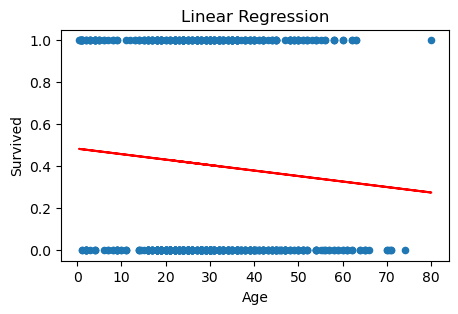

In [48]:
plt.figure(figsize=(5,3))
plt.scatter(Titanic['Age'], Titanic['Survived'], s=20)
plt.plot(Titanic['Age'], y_pred, color='red')
plt.title('Linear Regression', fontsize=12)
plt.xlabel('Age', fontsize=10)
plt.ylabel('Survived', fontsize=10)
plt.show()

**단순 로짓 모델 추정**

이번에는 단순 로짓 모델을 피팅해보기로 하자. 앞에서와 마찬가지로 반응변수는 생존 더미변수인 `Survived`이고, 예측변수는 `Age`이다. 로짓 모델을 피팅한 다음, 각 `Age` 값에 대해서 적합값(확률 추정값)을 구해 산점도 위에 그렸다.

In [49]:
model = smf.logit('Survived ~ Age', data=Titanic)
logitfit = model.fit()
y_pred = logitfit.predict(Titanic['Age'])

Optimization terminated successfully.
         Current function value: 0.672429
         Iterations 4


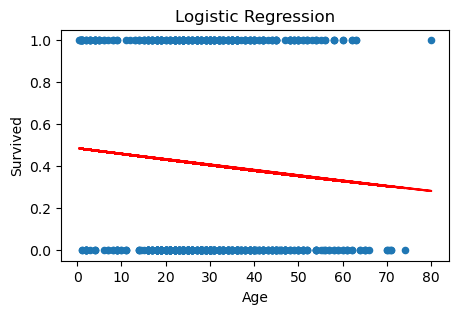

In [50]:
plt.figure(figsize=(5,3))
plt.scatter(Titanic['Age'], Titanic['Survived'], s=20)
plt.plot(Titanic['Age'], y_pred, color='red')
plt.title('Logistic Regression', fontsize=12)
plt.xlabel('Age', fontsize=10)
plt.ylabel('Survived', fontsize=10)
plt.show()

**선형 회귀선 vs. 로지스틱 회귀선 비교**

위 선형 모델과 로지스틱 모델은 둘 다 `Age`를 예측변수로 사용하여 생존 확률을 추정한 것이다. `Age`와 `Survived` 평면상의 산점도 위에 그려진 빨간색 선이 각 `Age` 값에 대해서 생존 확률을 추정한 적합값(fitted value)이다. 두 모델의 추정 회귀선을 비교해보면 거의 차이가 없는 것을 알 수 있다. 

우리는 앞에서 선형 모델의 경우 추정 확률이 0과 1 사이에서 벗어날 가능성이 있기 때문에 로지스틱 모델을 사용한다고 설명했는데, 사실 위 추정 결과를 보면 선형 모델 역시 추정된 생존 확률이 (`Age`의 가능한 범위 내에서) 0과 1 사이의 범위에서 벗어날 가능성은 전혀 없어 보인다. 이항(binary) 반응 데이터를 선형 회귀 모델로 추정하는 것이 완전히 엉뚱한 일은 아니라는 것을 보여준다. 

**다중 로짓 모델 추정**

이번에는 `Age` 변수뿐만 아니라 `Pclass`(티켓 등급), `Sex`(성별), `Sibsp`(승선한 형제/배우자 숫자), `Parch`(승선한 부모/자녀 숫자), `Fare`(여객 운임), `Embarked`(승선 항구) 등을 포함시켜 로지스틱 모델로 추정해보자. 

그런데 `Pclass`, `Sex`, `Embarked`는 범주형 변수이다. 앞에서도 설명했듯이 이런 범주형 변수를 예측변수로 사용할 경우, 우리가 굳이 더미변수를 만들어 넣지 않아도 `statsmodels` 모듈이 알아서 더미변수를 만들어 추정한다. 그런데 이때 유의할 점이 하나 있는데, `Pclass`(티켓 등급) 변수의 경우에는 티켓 등급의 범주가 1, 2, 3의 숫자로 돼있다는 점이다. 즉, 등급 범주가 문자로 표시된 것이 아니라 숫자로 돼있다. 이 경우 `Pclass`를 예측변수로 그대로 사용하면, `statsmodels` 모듈은 이것을 범주형 변수가 아니라 정량적 변수로 인식하여 더미변수를 만들지 않고 `Age` 등 다른 정량적 변수와 동일하게 취급한다. 이를 막기 위해서는(즉, 더미변수를 만들어 추정하도록 만들기 위해서는), 아래 나와 있는 것처럼 `Pclass`가 아니라 `C(Pclass)`로 표시해야 한다.

In [51]:
formula = 'Survived ~ C(Pclass) + Sex + Age + SibSp + Parch + Fare + Embarked'
model = smf.logit(formula, data = Titanic)
logitfit = model.fit()
print(logitfit.summary())

Optimization terminated successfully.
         Current function value: 0.444060
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:               Survived   No. Observations:                  712
Model:                          Logit   Df Residuals:                      702
Method:                           MLE   Df Model:                            9
Date:                Wed, 03 Sep 2025   Pseudo R-squ.:                  0.3419
Time:                        06:52:20   Log-Likelihood:                -316.17
converged:                       True   LL-Null:                       -480.45
Covariance Type:            nonrobust   LLR p-value:                 2.249e-65
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          4.4329      0.536      8.271      0.000       3.383       5.483
C(Pclass)[T.2]   

**추정 결과 해석**

`Embarked`(승선 항구), `Parch`(승선한 부모/자녀 숫자), `Fare`(여객 운임) 변수들은 타이타닉 생존 여부와 관련하여 통계적으로 유의하지 않다. `Pclass`(티켓 등급)의 경우 2등석 그룹은 1등석에 비해 생존 가능성이 더 낮고, 3등석 그룹은 1등석은 물론이고 2등석보다 생존 가능성이 더 낮은 경향이 있는 것으로 나타났다(통계적으로 유의함). 그밖에 남성일수록, 나이가 많을수록, 함께 승선한 형제/배우자 숫자가 많을수록 생존 가능성이 낮은 경향이 있는 것으로 나타났다(통계적으로 유의함).

### ChatGPT Q&A

>**다음은 타이타닉호 생존(Survived) 여부를 로짓 모델로 추정한 결과이다. 여기에서 age(나이) 변수의 추정 계수와 표준오차, z값, p값의 의미에 대해 알기 쉽게 설명해줘.**
>
>coef    std err          z      P>|z|      [0.025      0.975]  
>
>Intercept          4.4329      0.536      8.271      0.000       3.383       5.483  
C(Pclass)[T.2]    -1.1896      0.329     -3.614      0.000      -1.835      -0.544  
C(Pclass)[T.3]    -2.3952      0.343     -6.976      0.000      -3.068      -1.722  
Sex[T.male]       -2.6379      0.223    -11.829      0.000      -3.075      -2.201  
Embarked[T.Q]     -0.8234      0.600     -1.372      0.170      -2.000       0.353  
Embarked[T.S]     -0.4028      0.275     -1.467      0.142      -0.941       0.135  
Age               -0.0433      0.008     -5.204      0.000      -0.060      -0.027  
SibSp             -0.3629      0.129     -2.807      0.005      -0.616      -0.110  
Parch             -0.0604      0.124     -0.487      0.626      -0.303       0.183  
Fare               0.0015      0.003      0.559      0.576      -0.004       0.007  

---

>이 로지스틱 회귀 모델에서 'age' (나이) 변수의 추정 계수와 관련된 통계치들은 다음과 같은 의미를 가집니다:
>
>1. **계수 (coef): -0.0433**
>    - 이 값은 나이가 한 살 증가할 때마다 생존 확률의 로그 오즈(log odds)가 평균적으로 -0.0433만큼 변한다는 것을 의미합니다. 로그 오즈는 생존 확률과 사망 확률의 비율의 로그 값입니다. 여기서 계수가 음수이므로, 나이가 증가함에 따라 생존 확률이 감소한다는 것을 암시합니다.
>
>2. **표준오차 (std err): 0.008**
>    - 표준오차는 계수 추정치의 정확도를 나타냅니다. 낮은 표준오차는 더 정확한 추정치를 의미합니다. 여기서 표준오차가 0.008인 것은 이 계수 추정치가 일정한 정확도를 가지고 있음을 나타냅니다.
>
>3. **z 값: -5.204**
>    - z 값은 계수 추정치가 0인지 아닌지를 판단하기 위한 통계적 검정치입니다. 계수가 표준오차의 몇 배인지 나타냅니다. 여기서 z 값이 -5.204인 것은 계수가 표준오차보다 약 5.204배 더 멀리 떨어져 있다는 것을 의미하며, 이는 통계적으로 유의한 결과입니다.
>
>4. **p 값 (P>|z|): 0.000**
>    - p 값은 계수의 통계적 유의성을 나타냅니다. 일반적으로 p 값이 0.05 미만이면 계수가 통계적으로 유의미하다고 간주됩니다. 이 경우 p 값이 0.000으로 나타나므로, 'age' 변수의 계수는 통계적으로 매우 유의미합니다. 이는 나이가 생존 여부에 중요한 영향을 미친다는 것을 의미합니다.
>
>따라서 이 결과는 타이타닉호 데이터에서 나이가 증가함에 따라 생존 확률이 감소한다는 것을 통계적으로 유의미하게 보여줍니다.

**피팅 성과**

아래는 훈련 세트에 대해 혼동행렬을 구한 것이다. 생존 확률 분계점은 0.5를 사용했다.

In [52]:
logit_pred = pd.Series(logitfit.predict(Titanic) > 0.5).map({False: 0, True: 1})

In [53]:
cm = confusion_matrix(Titanic.Survived, logit_pred)  
cm_df = pd.DataFrame(cm, index=[0,1], columns=[0,1])
cm_df.index.name = 'True'
cm_df.columns.name = 'Predicted'
print(cm_df)
print()
print(classification_report(Titanic.Survived, logit_pred, digits=3))

Predicted    0    1
True               
0          365   59
1           85  205

              precision    recall  f1-score   support

           0      0.811     0.861     0.835       424
           1      0.777     0.707     0.740       290

    accuracy                          0.798       714
   macro avg      0.794     0.784     0.788       714
weighted avg      0.797     0.798     0.797       714



## 부록: 혼동행렬

**혼동행렬**(confusion matrix, 분류결과표)은 다음과 같이 모형이 예측한 범주가 실제 범주와 일치하는지를 표로 나타낸 것이다.

![혼동행렬](https://raw.githubusercontent.com/pilsunchoi/images/main/7-6.png)

### 사례

**(1) 금융 사기**
- True Positive: 사기를 사기라고 정확하게 예측
- True Negative: 정상을 정상이라고 정확하게 예측
- False Positive: 정상을 사기라고 잘못 예측
- False Negative: 사기를 정상이라고 잘못 예측

**(2) 코로나19 감염 진단**
- True Positive: 양성을 양성으로 정확하게 진단
- True Negative: 음성을 음성으로 정확하게 진단
- False Positive: 음성을 양성으로 잘못 진단
- False Negative: 양성을 음성으로 잘못 진단

### 다양한 평가기준

가령 100명 중 코로나19 바이러스 양성이 1명이고, 나머지 99명은 음성이라고 할 때, 진단 키트가 모든 사람을 무조건 음성이라고 판단할 경우, 정확도가 99%나 되지만 이 진단 키트가 우수하다고 말할 수는 없다. 정확도가 조금 떨어지더라도 양성을 제대로 포착해야 하기 때문이다. 그렇다고 너무 많은 false alarm이 있어서도 안 된다. 이는 우리가 어떤 진단(분류) 장비나 모델을 평가할 때, 정확도만으로 판단할 수는 없고 다양한 기준이 있어야 함을 의미한다.

**정확도(accuracy)**

전체 관측 중 올바르게 예측한 관측의 비율이다. 정확도가 높을수록 좋은 예측 모형이다.

$$
\rm accuracy= \frac {TP+TN}{TP+TN+FP+FN}
$$

**정밀도(precision)**

**양성으로 예측된 관측 중** 실제로 양성인 관측의 비율이다. 정밀도가 높을수록 좋은 예측 모형이다.

$$
\rm precision = \frac {TP}{TP+FP}
$$

**재현율(recall)**

**실제 양성 관측 중** 양성으로 예측된 관측의 비율이다. 재현율이 높을수록 좋은 예측 모형이다. 진양성률(TPR: true positive rate) 또는 **민감도**(sensitivity)라고도 한다.

$$
\rm sensitivity = \frac {TP}{TP+FN}
$$

**특이도(specificity)**

**실제 음성 관측 중** 음성으로 예측된 관측의 비율이다. 특이도가 높을수록 좋은 예측 모형이다. 진음성률(TNR: true negative rate)이라고도 한다. 

$$
\rm specificity = \frac {TN}{TN+FP}
$$

**위양성률(FPR)**

위양성률(FPR: false positive rate)은 실제 음성인데 양성으로 예측된 관측의 비율이다. fall-out이라고도 한다. 다른 평가점수와 달리 위양성률은 그 값이 낮을수록 좋다. 1에서 특이도를 빼면 위양성률이 나온다.  

$$
\rm FPR = 1 - specificity = \frac {FP}{TN+FP}
$$

### 사이킷런 혼동행렬 표 읽는 법

사이킷런(`sklearn`)이 제공하는 `classification_report()` 함수를 실행했을 때 반환되는 표의 각 항목들이 어떻게 계산된 것인지 알아보자. 

다음은 타이타닉 데이터세트를 다중 로짓 모델 추정한 후 `confusion_matrix()` 및 `classification_report()`를 실행한 결과이다.(앞의 마지막 분석 결과를 그대로 다시 가져온 것이다.) 표에 빨간색으로 적힌 1번부터 5번까지 번호 별로 해당 비율이 어떻게 계산되었는지 아래 설명이 나와 있다.

![혼동행렬 표](https://raw.githubusercontent.com/pilsunchoi/images/main/7-7.png)

**(1) accuracy**

전체 관측 중 올바르게 예측한 관측의 비율 => $\frac {365+205}{365+59+85+205}=0.798$

**(2) precision**

원래 정의는 양성으로 예측된 관측 중 실제로 양성인 관측의 비율이다. 그런데 어떤 범주가 "양성(positive)"인지 모르기 때문에 0과 1 범주 각각에 대해 precision을 계산한다. 

* 0이 양성일 때의 precision => 0으로 예측된 관측 중 실제로 0인 관측의 비율 => $\frac{365}{365+85}=0.811$


* 1이 양성일 때의 precision => 1로 예측된 관측 중 실제로 1인 관측의 비율 => $\frac{205}{59+205}=0.777$

**(3) recall**

원래 정의는 실제 양성 관측 중 양성으로 예측된 관측의 비율이다. 그런데 어떤 범주가 "양성(positive)"인지 모르기 때문에 0과 1 범주 각각에 대해 recall을 계산한다. 

* 0이 양성일 때의 recall => 실제로 0인 관측 중 0으로 예측된 관측의 비율 => $\frac{365}{365+59}=0.861$


* 1이 양성일 때의 recall => 실제로 1인 관측 중 1로 예측된 관측의 비율 => $\frac{205}{85+205}=0.707$

**(4) f1-score**

precision과 recall의 조화평균(harmonic mean)을 f1-score라고 하며, 다음과 같이 계산된다.

$$
 \text{f1-score} \rm= \frac {2 \times precision \times recall}{precision + recall}
$$

* 0을 양성으로 간주할 때의 f1-score => $\frac{2\times0.811\times0.861}{0.811+0.861}=0.835$


* 1을 양성으로 간주할 때의 f1-score => $\frac{2\times0.777\times0.707}{0.777+0.707}=0.740$

**(5) 평가점수 평균**

`macro avg`는 단순평균이고, `weighted avg`는 각 범주에 속하는 표본의 개수를 가중치로 하여 가중평균한 것이다. precision에 대해서만 평균을 계산해보면 다음과 같다.

* precision의 `macro avg` => $\frac{0.811+0.777}{2}=0.794$


* precision의 `weighted avg` => $\frac{424}{714}\times0.811+\frac{290}{714}\times0.777=0.797$